## 11.2. GTFS Schedule Analysis for the City of Riga

In [ ]:
pip install gtfs_functions

In [ ]:
pip install geoalchemy2

In [ ]:
pip install sqlalchemy 

In [ ]:
pip install dash

In [ ]:
pip install dash_bootstrap_components

In [1]:
# Libraries to be used in the following cells

import numpy as np
import pandas as pd
import geopandas as gpd
import gtfs_functions as gtfs
import json

# Database interaction
import psycopg
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import folium as fl
from IPython.display import display, HTML, clear_output


# Configure plot style
plt.style.use("fivethirtyeight")
plt.rcParams.update({'font.size': 9})

In [2]:
# Setup database connection

def load_db_config(config_path="config.json"):
    """
    Loads database configuration from a JSON file.
    
    Parameters:
    - config_path: Path to the configuration JSON file.
    
    Returns:
    - config: Dictionary containing database connection details.
    """
    with open(config_path, "r") as file:
        config = json.load(file)
    return config

def connect_postgres(config):
    """
    Connects to a PostgreSQL database using the given configuration.
    
    Parameters:
    - config: Dictionary containing database connection details.
    
    Returns:
    - cur: Cursor object for executing SQL queries
    """
    try:
        # Establish connection using configuration
        connection = psycopg.connect(
            host=config["DB_HOST"],
            port=config["DB_PORT"],
            user=config["DB_USER"],
            password=config["DB_PASS"],
            dbname=config["DB_NAME"]
        )
        
        # Create a cursor for executing queries
        cur = connection.cursor()
        
        # Fetch and print PostgreSQL details
        print("Connected to PostgreSQL:", connection.info.dsn)
        cur.execute("SELECT version();")
        print("PostgreSQL version:", cur.fetchone(), "\n")
        
        return cur

    except Exception as error:
        print("Error while connecting to PostgreSQL:", error)

# Load database configuration
db_config = load_db_config("config.json")

In [3]:
# Required before visualization scripts

def fetch_table_sample(cur, table_name, limit=5):
    """
    Fetches a sample of data from the specified table.
    
    Parameters:
    - cur: PostgreSQL cursor object
    - table_name: Name of the table to query
    - limit: Number of records to fetch (default=5)
    
    Returns:
    - DataFrame with fetched records
    """
    query = f"SELECT * FROM {table_name} LIMIT {limit};"
    cur.execute(query)
    columns = [desc[0] for desc in cur.description]
    return pd.DataFrame(cur.fetchall(), columns=columns)

# Connect to PostgreSQL
cur = connect_postgres(db_config)

# Fetch data samples from different tables
calendar_sample_df = fetch_table_sample(cur, 'calendar')
calendar_dates_sample_df = fetch_table_sample(cur, 'calendar_dates')
routes_sample_df = fetch_table_sample(cur, 'routes')
shapes_sample_df = fetch_table_sample(cur, 'shapes')
stop_times_sample_df = fetch_table_sample(cur, 'stop_times')
stops_sample_df = fetch_table_sample(cur, 'stops')
trips_sample_df = fetch_table_sample(cur, 'trips')
arrivals_departures_sample_df = fetch_table_sample(cur, 'arrivals_departures')
connections_sample_df = fetch_table_sample(cur, 'connections')

Connected to PostgreSQL: user=mahmoud dbname=urbanMobilityChapter host=localhost hostaddr=127.0.0.1 sslcertmode=allow
PostgreSQL version: ('PostgreSQL 16.6 (Ubuntu 16.6-0ubuntu0.24.04.1) on x86_64-pc-linux-gnu, compiled by gcc (Ubuntu 13.2.0-23ubuntu4) 13.2.0, 64-bit',) 



# Section 11.2.2. - Visualizing Transport Routes

In [4]:

import matplotlib.pyplot as plt

def visualize_network(cur):
    """
    Visualizes the transit network using the 'shapes_aggregated' view from PostgreSQL
    with OpenStreetMap (OSM) tiles as the map background.
    
    Parameters:
    - cur: PostgreSQL cursor object
    """
    # Query GeoDataFrame
    sql = 'SELECT * FROM shapes_aggregated;'
    shapes_gdf = gpd.GeoDataFrame.from_postgis(sql, cur.connection, geom_col='shape', crs='EPSG:4326')
    
    # Initialize a folium map with OpenStreetMap tiles
    map_all = fl.Map(location=[56.9496, 24.1052], tiles="https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png",
                         attr="OpenStreetMap", zoom_start=12)

    # Add GeoDataFrame as an overlay
    fl.GeoJson(
        shapes_gdf,
        name="All Routes",
        style_function=lambda x: {"color": "blue", "weight": 1, "fillOpacity": 0.5}
    ).add_to(map_all)

    # Add layer control to toggle layers
    fl.LayerControl().add_to(map_all)
    
    return map_all

# Visualize network
network_map = visualize_network(cur)
network_map.save("RigaNetwork.html")
network_map


# Section 11.2.2. - Visualizing Individual Lines

In [5]:
def map_individual_lines(cur):
    """
    Creates an interactive map to visualize individual transit lines from the 'shapes_aggregated' view
    using vector tiles as the map background.
    
    Parameters:
    - cur: PostgreSQL cursor object to execute SQL queries.
    """
    # SQL query to get the transit line shapes
    sql = 'SELECT * FROM shapes_aggregated;'
    shapes_gdf = gpd.GeoDataFrame.from_postgis(sql, cur.connection, geom_col='shape', crs='EPSG:4326')

    # Initialize the map centered on Riga with vector tiles
    map_indiv_lines = fl.Map(location=[56.937, 24.109], tiles=None, zoom_start=13, control_scale=True)

    # Vector Tile Service URL and Attribution (Example: OpenStreetMap or MapTiler)
    vector_tile_url = "https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png"
    vector_tile_attr = "OpenStreetMap"

    # Add vector tiles as the base layer
    fl.TileLayer(
        tiles=vector_tile_url,
        attr=vector_tile_attr,
        name="Vector Tiles",
        overlay=False,
        control=True
    ).add_to(map_indiv_lines)

    # Add each route as a FeatureGroup
    for shape_id, shape_group in shapes_gdf.groupby('shape_id'):
        # Initialize a feature group for each individual line (shape_id)
        feature_group = fl.FeatureGroup(name=f"Route {shape_id}", show=True)  # Initially show all routes by default
        
        # Add each LineString geometry as a PolyLine
        for geometry in shape_group.geometry:
            if geometry.geom_type == 'LineString':
                coords = [(lat, lon) for lon, lat in geometry.coords]  # Reverse coords from (lon, lat) to (lat, lon)
                fl.PolyLine(locations=coords, color="blue", weight=2, opacity=0.8).add_to(feature_group)

        # Add the feature group to the map
        feature_group.add_to(map_indiv_lines)

    # Add a layer control to toggle between different routes
    fl.LayerControl(collapsed=False).add_to(map_indiv_lines)

    return map_indiv_lines

# Generate the map
individual_lines_map = map_individual_lines(cur)

# Save the map
individual_lines_map.save("RigaNetworkIndividualLines.html")

# Display the map
display(individual_lines_map)


# 11.2.3. Splitting the Routes into Segments

INFO:root:Getting segments...
INFO:root:Reading "stop_times.txt".
INFO:root:get trips in stop_times
INFO:root:accessing trips
INFO:root:Reading "routes.txt".
INFO:root:Reading "trips.txt".
INFO:root:Reading "calendar.txt".
INFO:root:Reading "calendar_dates.txt".
INFO:root:The busiest date/s of this feed or your selected date range is/are:  ['2024-09-26', '2024-09-10', '2024-09-17', '2024-09-18', '2024-09-19', '2024-09-20', '2024-09-23', '2024-09-24', '2024-09-25', '2024-09-27', '2024-09-30', '2024-09-11', '2024-09-12', '2024-09-13', '2024-09-16'] with 7611 trips.
INFO:root:In the case that more than one busiest date was found, the first one will be considered.
INFO:root:In this case is 2024-09-26.
INFO:root:Reading "stop_times.txt".
INFO:root:_trips is defined in stop_times
INFO:root:Reading "stops.txt".
INFO:root:computing patterns
INFO:root:Reading "shapes.txt".
INFO:root:Projecting stops onto shape...
INFO:root:Interpolating stops onto shape...
INFO:root:Sorting shape points and sto

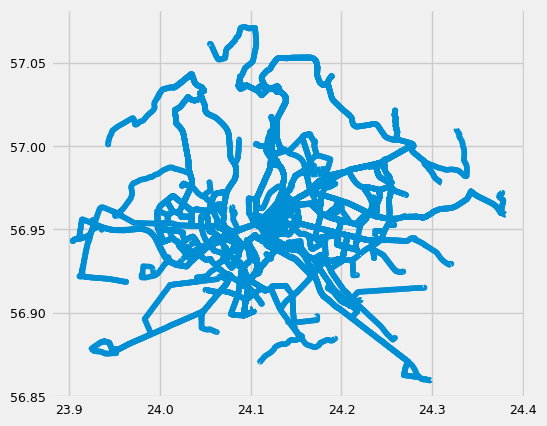

In [6]:
#Script for Section 11.2.3 

def load_gtfs_feed(file_path, start_date, end_date):
    """
    Loads the GTFS data from a ZIP file and plots the segments.
    
    Parameters:
    - file_path: Path to the GTFS zip file
    - start_date: Start date of the feed (format: YYYY-MM-DD)
    - end_date: End date of the feed (format: YYYY-MM-DD)
    """
    # Load GTFS feed
    feed = gtfs.Feed(file_path, start_date=start_date, end_date=end_date)
    segments_gdf = feed.segments

    # Plot GTFS segments
    segments_gdf.plot()
    return segments_gdf

# Load and plot GTFS feed
gtfs_file = "marsrutusaraksti08_2024.zip"
gtfs_segments = load_gtfs_feed(gtfs_file, '2024-09-01', '2024-09-30')

In [7]:
# Save segments to PostGIS
def save_to_postgis(gdf, table_name, config_path="config.json"):
    """
    Saves a GeoDataFrame to a PostgreSQL/PostGIS database.
    
    Parameters:
    - gdf: GeoDataFrame to save.
    - table_name: Name of the table where data will be stored.
    - config_path: Path to the database configuration JSON file (default: "config.json").
    """
    # Load database configuration from the JSON file
    config = load_db_config(config_path)
    
    # Construct the connection URL using the loaded configuration
    db_url = (
        f"postgresql://{config['DB_USER']}:{config['DB_PASS']}@"
        f"{config['DB_HOST']}:{config['DB_PORT']}/{config['DB_NAME']}"
    )
    
    # Create the SQLAlchemy engine using the constructed URL
    engine = create_engine(db_url)
    
    # Save the GeoDataFrame to PostGIS (PostgreSQL) using to_postgis()
    gdf.to_postgis(table_name, engine, if_exists='replace')
    
    print(f"Data saved to {table_name} table in the {config['DB_NAME']} database.")

save_to_postgis(gtfs_segments, "segments")


Data saved to segments table in the urbanMobilityChapter database.


# 11.2.4. Counting Scheduled Trips over Segments

In [ ]:
#Script for Section 11.2.4 (prepare for visualization)
from folium.features import GeoJsonTooltip

# Function to load segment data directly from PostGIS into a GeoDataFrame
def load_segments_from_postgis(conn):
    """
    Loads the segment data from a PostGIS database into a GeoDataFrame.
    
    Parameters:
    - conn: PostgreSQL connection object
    
    Returns:
    - GeoDataFrame containing segment information and geometries
    """
    query = """
    SELECT c.from_stop_id, c.from_stop_name, c.to_stop_id, c.to_stop_name, s.geometry, 
        count(trip_id) AS count, string_agg(distinct c.route_short_name, ',') AS routes
    FROM connections AS c 
    JOIN segments AS s 
    ON c.route_id=s.route_id AND c.direction_id=s.direction_id AND c.from_stop_id=s.start_stop_id 
       AND c.to_stop_id=s.end_stop_id
    WHERE date between '2024-09-01' and '2024-09-30'
    GROUP BY c.from_stop_id, c.from_stop_name, c.to_stop_id, c.to_stop_name, s.geometry;
    """
    
    # Load the query result into a GeoDataFrame
    segment_gdf = gpd.read_postgis(query, conn, geom_col="geometry")
    
    return segment_gdf

# Load database configuration
db_config = load_db_config("config.json")

# Connect to the PostgreSQL/PostGIS database using config.json details
conn = psycopg.connect(
    host=db_config["DB_HOST"],
    port=db_config["DB_PORT"],
    dbname=db_config["DB_NAME"],
    user=db_config["DB_USER"],
    password=db_config["DB_PASS"]
)  

# Load segments directly from PostGIS
segment_gdf = load_segments_from_postgis(conn)

# Close the database connection
conn.close()

# 11.2.4. Counting Scheduled Trips over Segments

In [ ]:
#Script for Section 11.2.4 (Visualization)
import branca.colormap as cm

# Function to visualize segments on a map
def visualize_segments(segment_data, cutoff=10000):
    """
    Visualizes the segments on a Folium map, where the color intensity
    gets darker for segments with a higher trip count (with a cutoff), and a legend is shown.
    
    Parameters:
    - segment_data: GeoDataFrame containing segment information and geometries
    - cutoff: Maximum value for the trip count to control color intensity
    
    Returns:
    - Folium map object displayed in the notebook
    """
    # Initialize a Folium map centered on Riga with no default tiles
    transport_map = fl.Map(location=[56.9496, 24.1052], tiles=None, zoom_start=12)

    # Add OpenStreetMap vector tiles
    fl.TileLayer(
        tiles="https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png",
        attr="OpenStreetMap",
        name="OSM Vector Tiles",
        overlay=False,
        control=True
    ).add_to(transport_map)

    # Define the colormap from white (low count) to red (high count), with a cutoff at 6000
    colormap = cm.LinearColormap(colors=['white', 'red'], vmin=0, vmax=cutoff, caption='Trip Count')
    colormap.add_to(transport_map)

    # Loop over each segment and add it to the map
    for _, segment in segment_data.iterrows():
        # Apply cutoff: any count above the cutoff is set to the maximum (cutoff value)
        trip_count = min(segment['count'], cutoff)
        
        # Get color based on trip count
        color = colormap(trip_count)
        
        # Convert the geometry to GeoJSON with associated properties
        geo_json = fl.GeoJson(
            data={
                "type": "Feature",
                "geometry": segment['geometry'].__geo_interface__,
                "properties": {
                    "routes": segment['routes'],
                    "from_stop_name": segment['from_stop_name'],
                    "to_stop_name": segment['to_stop_name'],
                    "count": segment['count']
                }
            },
            style_function=lambda x, color=color: {
                'color': color,
                'weight': 3,
                'opacity': 0.7
            },
            tooltip=GeoJsonTooltip(
                fields=['routes', 'from_stop_name', 'to_stop_name', 'count'],
                aliases=['Routes', 'From Stop', 'To Stop', 'Trip Count'],
                localize=True
            )
        )
        geo_json.add_to(transport_map)
    
    return transport_map

# Visualize the segments on a map with color intensity, cut off, and tooltips
transport_map = visualize_segments(segment_gdf)

# Save the map
transport_map.save("TripCountPerSegment.html")

# Display the map in the notebook
display(transport_map)

# 11.2.5. Analyzing the Planned Speed per Segment

In [ ]:
#Script for Section 11.2.5.

import pandas as pd
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.express as px
import dash_bootstrap_components as dbc

# Fetch detailed segment speed data
def fetch_segment_speeds():
    """
    Fetches the detailed speed values per segment from the PostGIS database.
    
    Returns:
    - DataFrame containing speed values and segment details
    """
    # Load database configuration
    db_config = load_db_config("config.json")
    
    # Connect to the PostgreSQL/PostGIS database using config.json details
    conn = psycopg.connect(
        host=db_config["DB_HOST"],
        port=db_config["DB_PORT"],
        dbname=db_config["DB_NAME"],
        user=db_config["DB_USER"],
        password=db_config["DB_PASS"]
    )  
    
    query = """
    SELECT (s.distance_m / EXTRACT(EPOCH FROM (c.t_arrival - c.t_departure)) * 3.6) AS speedKMH,
           c.from_stop_id, c.from_stop_name, c.to_stop_id, c.to_stop_name
    FROM connections AS c
    JOIN segments AS s
    ON c.route_id=s.route_id 
       AND c.direction_id=s.direction_id 
       AND c.from_stop_id=s.start_stop_id 
       AND c.to_stop_id=s.end_stop_id
    WHERE date BETWEEN '2024-09-01' AND '2024-09-30' 
      AND EXTRACT(EPOCH FROM (c.t_arrival - c.t_departure)) > 0;
    """
    df = pd.read_sql_query(query, conn)
    conn.close()
    
    # Add a column that concatenates 'from_stop_name' and 'to_stop_name' for easy selection
    df['segment'] = df['from_stop_name'] + " -> " + df['to_stop_name']
    
    return df

# Initialize Dash app
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

# Load data
speed_df = fetch_segment_speeds()

# Layout of the Dash app
app.layout = dbc.Container([
    html.H1("Speed Distribution per Segment"),
    
    # Dropdown for selecting segment
    dcc.Dropdown(
        id="segment-dropdown",
        options=[{"label": seg, "value": seg} for seg in sorted(speed_df['segment'].unique())],
        value=speed_df['segment'].unique()[0],  # Default value
        clearable=False,
        style={"width": "80%"}
    ),
    
    # Graph to display speed distribution
    dcc.Graph(id="speed-distribution-plot")
])

# Callback to update the graph based on selected segment
@app.callback(
    Output("speed-distribution-plot", "figure"),
    Input("segment-dropdown", "value")
)
def update_graph(selected_segment):
    # Filter data for the selected segment
    segment_df = speed_df[speed_df['segment'] == selected_segment]
    
    # Create histogram for the speed distribution
    fig = px.histogram(segment_df, x="speedkmh", nbins=30, title=f"Speed Distribution for {selected_segment}",
                       labels={"speedkmh": "Speed (km/h)"})
    
    # Ensure the bar doesn't stretch too wide by setting a reasonable x-axis range
    if not segment_df['speedkmh'].empty:
        speed_min = segment_df['speedkmh'].min() - 5  # Padding for better visibility
        speed_max = segment_df['speedkmh'].max() + 5
        fig.update_xaxes(range=[speed_min, speed_max])
        
    fig.update_layout(xaxis_title="Speed (km/h)", yaxis_title="Frequency")
    
    return fig

# Run the app
if __name__ == "__main__":
    app.run_server(port=8051)